# Predicting Customer Churn with getML on H&M Fashion Dataset

## Introduction
This notebook showcases how to use [getML](https://getml.com) to predict customer churn with the [H&M Personalized Fashion Recommendations dataset](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data).
The goal is to demonstrate how even a simple, untuned getML model can outperform competing approaches on real-world, multi-table datasets with minimal effort.

### Why use getML FastProp?
- *Relational Learning.* FastProp (short for Fast Propositionalization) extracts features from related tables without manual SQL or deep business domain expertise.
- *Blazing Fast.* FastProp runs [60 to 1000 times faster](https://github.com/getml/getml-community?tab=readme-ov-file#benchmarks) than alternatives like [featuretools](https://www.featuretools.com) or [tsfresh](https://tsfresh.com), scaling easily to millions of rows.
- *Superior Performance.* FastProp frequently outperforms graph neural networks and models with handcrafted features on relational learning tasks.

The hm-churn dataset consists of:
- 3 Tables (Customers, Articles, Transactions)
- 37 Columns in total
- ~33 million rows

This dataset is part of the [Relational Deep Learning Benchmark (RelBench)](http://relbench.stanford.edu/),
maintained at Stanford, which standardizes relational learning tasks.

### Outline

1. [Setup](#1.-Setup)
2. [Loading Data into getML, Inspecting, and Setting Roles (Data Annotation)](#2.-Loading-Data-into-getML,-Inspecting,-and-Setting-Roles-(Data-Annotation))
3. [Define the getML DataModel](#3.-Defining-the-getML-DataModel)
4. [Create a getML Container referncing the Data](#4.-Creating-a-getML-Container-referencing-the-Data)
5. [Define the Pipeline and Check the Data](#5.-Defining-the-getML-Pipeline-and-Checking-the-Data)
6. [Fitting and Scoring the Pipeline](#6.-Fitting-and-Scoring-the-getML-Pipeline)
7. [Explore Feature Importances](#7.-Feature-Importances)
8. [Explore Column Importances](#8.-Column-Importances)

---
## 1. Setup

> <span style="font-weight: 500; color: #3b3b3b;">ⓘ️&nbsp; Note</span>
>
> We have prepared an [environment with all necessary dependencies](pyproject.toml) for you. To to use it, just start jupyter lab through `uv run jupyter lab` from the repository root.

In this step, we:
- Import necessary libraries
- Set a getML project
- Download the "rel-hm" dataset and "user-churn" task from RelBench

The "rel-hm" dataset represents relational data on customer interactions,
and the "user-churn" task focuses on predicting customer churn.


In [1]:
import getml
from relbench.datasets import get_dataset
from relbench.tasks import get_task

dataset = get_dataset("rel-hm", download=True)
task = get_task("rel-hm", "user-churn", download=True)

# Enable textual output to avoid rendering issues in certain JupyterLab environments
getml.utilities.progress.FORCE_TEXTUAL_OUTPUT = True
getml.utilities.progress.FORCE_MONOCHROME_OUTPUT = True

# Launch getML engine in memory-mapped mode to handle large datasets
# Requires less memory (RAM) but is slightly slower.
getml.engine.launch(in_memory=False)

# Set the project name in getML for tracking and managing objects
getml.set_project("hm-churn")

getML Engine is already running.
  Loading pipelines... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


Connected to project 'hm-churn'.

---
## 2. Loading Data into getML, Inspecting, and Setting Roles (Data Annotation)

> <span style="font-weight: 500; color: #3b3b3b;">ⓘ️&nbsp; Note</span>
>
> While the `relbench` library provides a high-level API to load datasets and tasks into pandas dataframes,
> we will use getML's native `DataFrame` API to load the data directly into getML to speed up the process.

The H&M user-churn dataset is provided by relbench as a [dataset](https://relbench.stanford.edu/start/) of multiple tables:
- `customer`
- `article`
- `transaction`

The target variable `churn` is provided as a [task](https://relbench.stanford.edu/start/). I getML, we
refer to table containing the target variable as the [population table](https://getml.com/latest/user_guide/concepts/data_model/#the-population-table):
- population (train/test/val splits) with the target variable `churn`

### Objectives:
- Load each table from disk
- Inspect columns to understand the schema
- Assign appropriate roles (join_key, time_stamp, numerical, categorical, etc.)

### Why Roles Matter
[`Roles`](https://getml.com/latest/user_guide/concepts/annotating_data/#annotating-data-roles) allow getML to:
- Efficiently encode links between tables (`join_key`)
- Interpret timestamps for time-aware modeling (`time_stamp`)
- Encode numerical, categorical, and text features (`numerical`, `categorical`, `text`)
- Ignore irrelevant columns (`unused_float` or `unused_string`)


### a. Customer Table

In [2]:
customer = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/customer.parquet", "customer"
)

# Inspect the structure of the customer table
customer

name,customer_id,FN,Active,age,club_member_status,fashion_news_frequency,postal_code
role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,0,nan,nan,49,ACTIVE,NONE,52043ee2162cf5aa7ee79974281641c6...
1,1,nan,nan,25,ACTIVE,NONE,2973abc54daa8a5f8ccfe9362140c632...
2,2,nan,nan,24,ACTIVE,NONE,64f17e6a330a85798e4998f62d0930d1...
3,3,nan,nan,54,ACTIVE,NONE,5d36574f52495e81f019b680c843c443...
4,4,1,1,52,ACTIVE,Regularly,25fa5ddee9aac01b35208d01736e5794...
,...,...,...,...,...,...,...
1371975,1371975,nan,nan,24,ACTIVE,NONE,7aa399f7e669990daba2d92c577b5223...
1371976,1371976,nan,nan,21,ACTIVE,NONE,3f47f1279beb72215f4de557d950e0bf...
1371977,1371977,1,1,21,ACTIVE,Regularly,4563fc79215672cd6a863f2b4bf56b8f...


In [3]:
# Role assignment breakdown on `customer`:
# - `customer_id`: Acts as the primary key, linking to other tables → `join_key`
# - `age`: Numerical data representing customer age → `numerical`
# - `FN`, `Active`, `club_member_status`, `fashion_news_frequency`, `postal_code`: Categorical data → `categorical`

# Note that `Active` is categorical variables despite being encoded as floats.
# We set the role as `categorical` since the column has no inherent numerical relationship.

customer.set_role("customer_id", getml.data.roles.join_key)

customer.set_role(["age"], getml.data.roles.numerical)

customer.set_role(
    ["FN", "Active", "club_member_status", "fashion_news_frequency", "postal_code"],
    getml.data.roles.categorical,
)

### b. Article Table

In [4]:
article = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/article.parquet", "article"
)

article

name,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_code,index_name,index_group_name,section_name,garment_group_name,detail_desc
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,0,108775,253,1010016,9,4,5,1676,1,16,1002,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
1,1,108775,253,1010016,10,3,9,1676,1,16,1002,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
2,2,108775,253,1010017,11,1,9,1676,1,16,1002,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
3,3,110065,306,1010016,9,4,5,1339,1,61,1017,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,B,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",Microfibre T-shirt bra with unde...
4,4,110065,306,1010016,10,3,9,1339,1,61,1017,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,B,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",Microfibre T-shirt bra with unde...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,105537,953450,302,1010014,9,4,5,7188,3,26,1021,5pk regular Placement1,Socks,Socks & Tights,Placement print,Black,Dark,Black,Socks Bin,F,Menswear,Menswear,Men Underwear,Socks and Tights,Socks in a fine-knit cotton blen...
105538,105538,953763,253,1010016,9,4,5,1919,1,2,1005,SPORT Malaga tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey,A,Ladieswear,Ladieswear,H&M+,Jersey Fancy,Loose-fitting sports vest top in...
105539,105539,956217,265,1010016,9,4,5,1641,1,18,1005,Cartwheel dress,Dress,Garment Full body,Solid,Black,Dark,Black,Jersey,A,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy,"Short, A-line dress in jersey wi..."


Role assignment breakdown on `article`:
`article_id` acts as the primary key for joining with the transaction table.
Numerical-encoded categories (e.g., `product_type_no`) are set as categorical

In [5]:
article.set_role("article_id", getml.data.roles.join_key)

article.set_role(
    [
        "product_group_name",
        "department_name",
        "garment_group_name",
        "product_code",
        "product_type_no",
        "graphical_appearance_no",
        "colour_group_code",
        "perceived_colour_value_id",
        "perceived_colour_master_id",
        "department_no",
        "index_group_no",
        "section_no",
        "garment_group_no",
    ],
    getml.data.roles.categorical,
)

### c. Transaction Table
Looking at the [data model](#hm-datamodel-overview) is already suffient to derive the most important roles for `transaction`:
- `customer_id` and `article_id` are join keys linking to the customer and article tables.
- `t_dat` serves as the time stamp, preventing data leakage by ensuring correct temporal boundaries.
- `price` is numerical, while `sales_channel_id` is categorical.

So in the follwing, we can directly assign the roles upon loading the data.

In [6]:
transaction_roles = getml.data.Roles(
    join_key=["article_id", "customer_id"],
    time_stamp=["t_dat"],
    numerical=["price"],
    categorical=["sales_channel_id"],
)

transaction = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/transactions.parquet", "transaction", transaction_roles
)

### d. Population tables (train, test, val)
The population table holds the statiscal population for the iference task at hand. Thus,
it is the table that holds the target variable, the possible reference dates (to prevent data leakage),
and is split into train, test, and validation sets. The population table is the canonical table data
scientist are used to work with in "classical", tabular machine learning tasks. It is the table that will be
handed over to the machine learning algorithm for training and prediction, and therefore is the target
entity for the feature learning process.

As where are just loading the relbench task, the population table is already split into train, test, and val and contains
nothing else than the target variable (`churn`), the primary key (`customer_id`), and the reference date (`timestamp`). Accoringly,
we assing the following roles:
- `customer_id` is the join key.
- `churn` is the target variable.
- `timestamp` represents the prediction or cut-off date to prevent data leakage.

In [7]:
population_roles = getml.data.Roles(
    join_key=["customer_id"], target=["churn"], time_stamp=["timestamp"]
)

train = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/tasks/user-churn/train.parquet", "train", population_roles
)

val = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/tasks/user-churn/val.parquet", "val", population_roles
)
test = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/tasks/user-churn/test.parquet", "test", population_roles
)

---
## 3. Defining the getML DataModel

In getML, the [`DataModel`](https://getml.com/latest/user_guide/concepts/data_model/) serves as the foundation for relational feature learning. The DataModel acts as the search space for features, similar to the schema of a relational database. It defines the universe of possible feature paths that getML’s algorithms can explore and learn from.

The data model is structured as a Directed Acyclic Graph, where each [join path](https://getml.com/latest/user_guide/concepts/data_model/#joins) represents a potential feature learning route. This structure enables automatic extraction of predictive signals (features) from complex, multi-table datasets.

Trivial joins ([one-to-one](https://getml.com/latest/reference/data/relationship/#getml.data.relationship.one_to_one) or [many-to-one](https://getml.com/latest/reference/data/relationship/#getml.data.relationship.many_to_one)) onto the population don’t produce new feature learning routes but columns in such tables are added to the main table _as is._ So, these paths are useful for enriching data but aren’t part of the feature learning process.

### H&M DataModel Overview
<img src="https://relbench.stanford.edu/img/rel-hm.png" width="500"/>

* The primary feature learning path is the [*one-to-many* relationship](https://getml.com/latest/reference/data/relationship/#getml.data.relationship) between the `population` table and the `transactions` table. This is where most valuable features are derived.
* The `customer` and `article` tables enrich the `population` and `transactions` tables, through tirival joins. However, only the article table introduces new feature learning paths, that the feature learner can aggregate over.

#### Key Concepts:
* The [`DataModel`](https://getml.com/latest/user_guide/concepts/data_model/) is abstract. It defines the relational structure but does not contain any data itself.
* [`Placeholders`](https://getml.com/latest/user_guide/concepts/data_model/#placeholders) represent tables in the model. These placeholders mirror the schema of actual DataFrames but are decoupled from raw data until the point of training.

In [8]:
# 1. Derive the population placeholder from the “train” DataFrame in our populations dict.
#    These rows form our target population for learning and prediction (we could
#    also use val or test here, as those share the same schema).
dm = getml.data.DataModel(population=train.to_placeholder())

# 2. Add placeholders for customer, transaction, and article tables.
#    These tables hold valuable information relevant to predictions.
#    Without this step, the predictor cannot access the knowledge within
#    these tables, leading to poorer model performance.
dm.add(getml.data.to_placeholder(customer, transaction, article))

# 3. Specify relational links:
#    - population -> customer on "customer_id" (many-to-one)
#    - population -> transaction on "customer_id" with time_stamps to prevent data leakage
#    - transaction -> article on "article_id" (many-to-one)
dm.population.join(
    dm.customer, on="customer_id", relationship=getml.data.relationship.many_to_one
)

dm.population.join(dm.transaction, on="customer_id", time_stamps=("timestamp", "t_dat"))

dm.transaction.join(
    dm.article, on="article_id", relationship=getml.data.relationship.many_to_one
)

dm

,data frames,staging table
0,"train, customer",TRAIN__STAGING_TABLE_1
1,"transaction, article",TRANSACTION__STAGING_TABLE_2


---
## 4. Creating a getML Container referencing the Data

The [`Container`](https://getml.com/latest/reference/data/container/#getml.data.Container) holds _all_ data (i.e. populatation, split into train, test, val, _and_ all peripheral tables: customer, transaction, article).
The actual data in a container will be linked to the abstract [**DataModel**](https://getml.com/latest/reference/data/data_model/) during training.

Why a Container is an important construct:
- `Container` is a convenience API that eases handling of relational data for Machine Learning tasks
- The DataModel defines the relational structure; the Container holds references to the actual data.
- During `pipeline.fit(container.train)`, the Container maps [*data*](https://getml.com/latest/reference/data/data_frame/) to [*placeholders*](https://getml.com/latest/reference/data/placeholder/),
  allowing getML to apply relational joins and time constraints for feature learning.
- No data is duplicated – the Container references the original tables, ensuring efficiency.
- A container allows you to easily pass around relational datasets for training, validation, and testing: E.g. `container.train` holds a [Subset](https://getml.com/latest/reference/data/subset/) that contains the training data for the population and all related peripheral tables.

This separation enhances reproducibility and keeps data handling modular.

In [10]:
# The constructor of receives the population tables (in this case already split into train, test, val)
container = getml.data.Container(train=train, val=val, test=test)

# `add` adds peripheral tables to the container
container.add(customer, transaction, article)

# Display the container to verify all splits and tables are correctly loaded.
container

population
    subset   name       rows   type     
0   train    train   3832692   DataFrame
1   test     test      74575   DataFrame
2   val      val       76556   DataFrame

peripheral
    name              rows   type     
0   customer       1371980   DataFrame
1   transaction   15453651   DataFrame
2   article         105542   DataFrame

---
## 5. Defining the getML Pipeline and Checking the Data

Our [pipeline](https://getml.com/latest/reference/pipeline/) will:
  - Use the DataModel (dm) to understand table relationships,
  - Use [FastProp](https://getml.com/latest/reference/feature_learning/fastprop/) for automated feature engineering,
  - Use [XGBoostClassifier](https://getml.com/latest/reference/predictors/xgboost_classifier/) for prediction.

### Why FastProp is Critical 🚀

[FastProp](https://getml.com/latest/reference/feature_learning/fastprop/) (short for Fast Propositionalization) is getML’s open source algorithm for feature learning.
It performs *propositionalization:* transforming relational and time-series data
into a flat table of predictive features through a series of pre-defined aggregations, enabling machine learning models to leverage predictive signals from complex, relational or time-series data.

#### Key Advantages of FastProp:
 - *Speed:* FastProp is up to [*60 to 1000 times faster*](https://github.com/getml/getml-community?tab=readme-ov-file#benchmarks) than competing tools like
   [featuretools](https://www.featuretools.com) and [tsfresh](https://tsfresh.com).
 - *Efficiency:* Faster feature generation allows for more iterations, boosting productivity.
 - *Accuracy:* Despite faster runtimes, FastProp displays *superior predictive performance*, as shown in benchmark results across various datasets.


In [11]:
pipe = getml.Pipeline(
    tags=["base_pipeline"],
    data_model=dm,
    feature_learners=[getml.feature_learning.FastProp(num_threads=16)],
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    predictors=[getml.predictors.XGBoostClassifier(n_jobs=16)],
)

# .check(...) does an analysis on the pipeline, data model and container
# to see if everything is consistent (time relationships, roles, table joins, etc.).
# We pass the 'train' subset for verification
pipe.check(container.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:21
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:05


The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.

,type,label,message
0,INFO,MIGHT TAKE LONG,The number of unique entries in column 't3__postal_code' in TRAIN__STAGING_TABLE_1 is 319891. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
1,INFO,MIGHT TAKE LONG,The number of unique entries in column 't4__product_code' in TRANSACTION__STAGING_TABLE_2 is 33580. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').


In [12]:
# Based on the info- and warning-messages, we might decide to mark certain columns unused.
# In this example, we realize that `product_code` or `postal_code` are not helpful:
article.set_role("product_code", getml.data.roles.unused_string)
customer.set_role("postal_code", getml.data.roles.unused_string)

# Because roles have changed and containers assume immutable data for consistency,
# we have to explicitly sync the container again to reflect the changes.
container.sync()

---
## 6. Fitting and Scoring the getML Pipeline

In [13]:
# .fit(...) orchestrates learning the features, and training the prediction model.

pipe.fit(container.train, check=False)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:23
  FastProp: Trying 64 features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:20
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 01:52


Trained pipeline.

Time taken: 0:02:35.832171.



Pipeline(data_model='train',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['article', 'customer', 'transaction'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['base_pipeline', 'container-dvBNmN'])

In [ ]:
# We now evaluate the pipeline on the validation and test sets:

pipe.score(container.val)
pipe.score(container.test)

Observing the results in pipe.scores, we find the current pipeline
meets our performance needs. Therefore, we will skip further optimizations
of the data model, feature learner, or pipeline hyperparameters at this stage.

As a final step, we will explore feature importances, column importances,
and examine the logical structure of our learned features. This helps us
understand how the pipeline is deriving its predictions and whether
certain aspects of the data are particularly influential.

---
## 7. Feature Importances

Since we used XGBoost, we can query each engineered feature's importance.
This helps us to understand which features matter for churn.

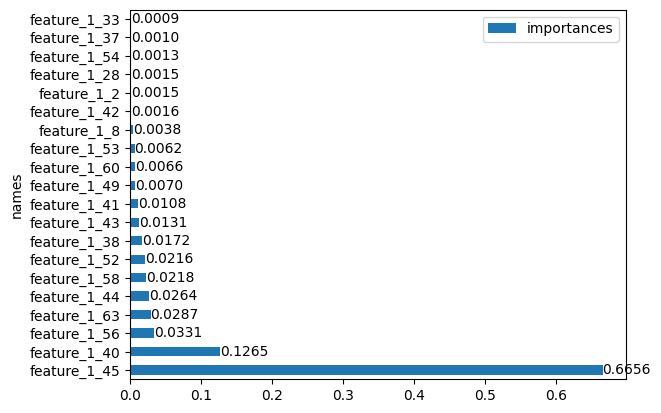

In [15]:
# Plot the top 20 features by importance
ax = (
    pipe.features.sort(by="importances")[:20]
    .to_pandas()
    .plot.barh(y="importances", x="names")
)
_ = ax.bar_label(ax.containers[0], fmt="%.4f")

If you want to see the underlying SQL logic for the top features:

In [16]:
# Top 1
pipe.features.sort(by="importances")[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_45";

CREATE TABLE "FEATURE_1_45" AS
SELECT COUNT( DISTINCT t2."t_dat" ) AS "feature_1_45",
       t1.rowid AS rownum
FROM "TRAIN__STAGING_TABLE_1" t1
INNER JOIN "TRANSACTION__STAGING_TABLE_2" t2
ON t1."customer_id" = t2."customer_id"
WHERE t2."t_dat" <= t1."timestamp"
GROUP BY t1.rowid;
```

This feature is the count of distinct transaction dates for a given customer prior to the churn-prediction timestamp. In simpler terms, "How many separate shopping days has the customer had?"

In [17]:
# Top 2
pipe.features.sort(by="importances")[1].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_40";

CREATE TABLE "FEATURE_1_40" AS
SELECT TREND( t2."t_dat", t1."timestamp" - t2."t_dat" ) AS "feature_1_40",
       t1.rowid AS rownum
FROM "TRAIN__STAGING_TABLE_1" t1
INNER JOIN "TRANSACTION__STAGING_TABLE_2" t2
ON t1."customer_id" = t2."customer_id"
WHERE t2."t_dat" <= t1."timestamp"
GROUP BY t1.rowid;
```

`TREND` is a function that measures how transaction dates cluster over time, indicating momentum or recency in the user's shopping behavior.

---
## 8. Column Importances

Beyond feature importances, getML can also compute *column importances,* showing how each original column (like `age`, `price`, or `department_name`) contributed overall to the final model.
This is particularly useful if you want to prune entire columns that have negligible relevance for churn. If, for example `colour_group_code` or `department_no` are extremely low, we might decide
to remove them. This is valuable when dealing with very large data to speed up the pipeline and reduce noise.

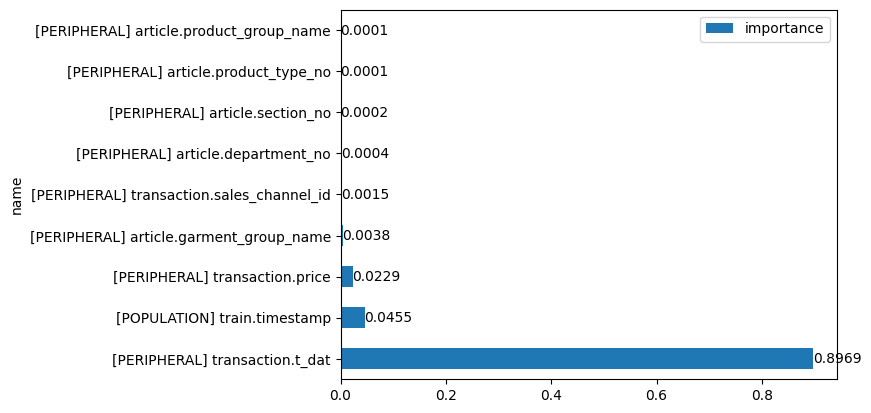

In [18]:
# Plot the top 10 columns by importance
ax = (
    pipe.columns.sort(by="importances")[:10]
    .to_pandas()
    .assign(name=lambda c: c.marker.str.cat(c.table, sep=" ").str.cat(c.name, sep="."))
    .plot.barh(y="importance", x="name")
)
_ = ax.bar_label(ax.containers[0], fmt="%.4f")

---
## Conclusion

In this notebook, we demonstrated how to build a *time-aware, relational* model for customer churn prediction using getML. We:
1. Loaded and annotated the data (population, transactions, articles, and customers),
2. Defined a DataModel to represent their relationships,
3. Applied getML's FastProp for automated feature engineering using propositionalization,
4. Trained an XGBoostRegressor to predict item-level sales,
5. Evaluated performance on validation and test sets,
6. Analyzed feature and column importances for interpretability.

This provides a solid foundation for churn prediction. While further tuning and feature engineering can enhance accuracy, this analysis highlights the strength of getML in terms of model performance, ease of use, and interpretability with minimal code.

### Next Steps
To explore model tuning or integrate custom predictors with getML's features, check out [hm-item.ipynb](hm-item.ipynb) in this repository, which focuses on item sales prediction using regression techniques.